In [1]:
import torch
import torch.nn
import torch.nn.functional as F

In [2]:
from model.encoder import Encoder
from model.decoder import Decoder

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [4]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
from matplotlib import cm
import numpy as np
from dataset import get_dataset, collate_fn, vocab_size, int2char, char2int, SOS_CHAR, EOS_CHAR
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import ScaleImageByHeight, PaddingWidth, AverageMeter, accuracy

In [5]:
char2int[EOS_CHAR]

10

In [6]:
config = {
    'batch_size': 32,
    'hidden_size': 256,
    'attn_size': 256,
    'max_length': 10,
    'n_epochs_decrease_lr': 15,
    'start_learning_rate': 1e-5,  # NOTE: paper start with 1e-8
    'end_learning_rate': 1e-11,
    'depth': 4,
    'n_blocks': 3,
    'growth_rate': 96,
}

In [7]:
MAX_LENGTH = config['max_length']
CKPT_DIR = './ckpt'

In [8]:
info = torch.load(os.path.join(CKPT_DIR, 'BEST_weights2.pt'), map_location='cpu')

In [9]:
image_transform = transforms.Compose([
    transforms.Grayscale(3),
    ScaleImageByHeight(64),
    PaddingWidth(64),
    transforms.ToTensor(),
])

In [10]:
test_data = get_dataset('test', image_transform)
test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn, num_workers=2)

In [11]:
encoder = Encoder(config['depth'], config['n_blocks'], config['growth_rate'])
if info['encoder_state'] is not None:
    encoder.load_state_dict(info['encoder_state'])

In [12]:
decoder = Decoder(encoder.n_features,
                  config['hidden_size'], vocab_size, config['attn_size'])
if info['decoder_state'] is not None:
    decoder.load_state_dict(info['decoder_state'])

In [13]:
encoder = encoder.to(device)
decoder = decoder.to(device)

In [14]:
encoder.eval()
decoder.eval();

In [15]:
test_iter = iter(test_loader)

In [16]:
imgs, targets, targets_onehot, lengths = next(test_iter)

In [17]:
imgs.size()

torch.Size([32, 3, 64, 198])

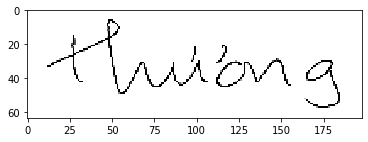

In [18]:
plt.imshow(imgs[0].squeeze().permute(1,2,0))

In [19]:
targets.size()

torch.Size([8, 32, 1])

In [20]:
''.join([int2char[x.item()] for x in targets[:,0].squeeze()])

'<start>thương<end>'

In [21]:
start_input = torch.zeros(1, config['batch_size'], vocab_size)
start_input[0,:, char2int[SOS_CHAR]] = 1
start_input = start_input.to(device)

In [22]:
start_input[0][1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [23]:
with torch.no_grad():
#     for i, (imgs, targets, targets_onehot, lengths) in enumerate(val_loader):
    imgs = imgs.to(device)
    img_features = encoder(imgs)
    outputs, weights = decoder.greedy(img_features, start_input)

In [24]:
outputs.size()

torch.Size([10, 32, 150])

In [25]:
outputs

tensor([[[ 1.0110,  0.2254,  0.9469,  ..., -2.1018, -1.6080, -1.8388],
         [ 0.7959,  0.2056,  0.4836,  ..., -1.8986, -1.6150, -1.6749],
         [-0.0563, -0.0799,  0.5224,  ..., -1.5937, -1.5112, -1.6237],
         ...,
         [ 0.8817,  0.2908,  0.6819,  ..., -1.9380, -1.6017, -1.6673],
         [ 0.5098,  0.6124,  0.9090,  ..., -1.9300, -1.5843, -1.7969],
         [ 0.9420,  0.3022,  0.7105,  ..., -1.9758, -1.6601, -1.6571]],

        [[-1.8145,  1.7662,  1.0183,  ..., -2.4866, -2.0483, -2.8039],
         [-2.6930,  0.3823, -0.4094,  ..., -2.7267, -2.8701, -3.4035],
         [-0.6659,  2.3314,  1.0918,  ..., -2.0502, -2.3266, -2.4593],
         ...,
         [-1.1195,  3.0901,  1.2841,  ..., -0.1035, -0.7827, -1.1664],
         [-1.2306,  1.4710,  3.1208,  ..., -0.0348, -0.5162, -0.5971],
         [ 0.3182,  5.9701,  6.1283,  ..., -1.0217, -1.3455, -1.3291]],

        [[-2.9117, -1.2693, -2.1463,  ..., -2.9695, -2.3703, -2.5103],
         [-0.9312, -1.6187, -2.2954,  ..., -2

In [26]:
outputs[0].topk(2, -1)

torch.return_types.topk(
values=tensor([[13.7252,  6.1371],
        [16.0246,  6.2583],
        [14.9448,  6.4116],
        [16.2151,  6.1102],
        [15.1700,  6.4403],
        [15.8822,  6.3598],
        [15.7985,  6.1489],
        [16.0226,  6.2141],
        [15.7436,  6.1056],
        [15.0835,  6.1390],
        [15.5650,  6.1915],
        [15.7368,  6.2451],
        [14.5944,  6.1062],
        [15.8449,  6.3149],
        [16.1575,  6.1518],
        [15.9303,  6.2910],
        [15.3526,  6.5226],
        [14.2780,  6.4318],
        [15.2043,  6.3518],
        [15.8544,  6.2389],
        [15.8314,  6.2564],
        [15.9513,  6.2158],
        [15.9150,  6.0990],
        [13.3942,  5.8771],
        [15.9914,  6.1830],
        [11.4708,  8.0378],
        [14.2187,  6.9744],
        [11.1039,  7.1362],
        [16.0320,  6.1780],
        [15.2953,  6.3331],
        [12.5810,  6.5578],
        [15.7787,  6.2445]]),
indices=tensor([[12, 57],
        [12, 57],
        [12, 57],
        

In [27]:
x = torch.tensor([[1, 2,9,87],[6, 32,8,1],[4,6,7,2],[3,6,2,6]])
print("x",x)
values, indices = torch.topk(x,k=2,dim=-1)
print("values",values)
print("indices",indices)

x tensor([[ 1,  2,  9, 87],
        [ 6, 32,  8,  1],
        [ 4,  6,  7,  2],
        [ 3,  6,  2,  6]])
values tensor([[87,  9],
        [32,  8],
        [ 7,  6],
        [ 6,  6]])
indices tensor([[3, 2],
        [1, 2],
        [2, 1],
        [1, 3]])


In [28]:
_, index = outputs.topk(1, -1)

In [29]:
index.size()

torch.Size([10, 32, 1])

In [30]:
predicts = index.squeeze().transpose(0, 1) # [B, T]
predicts_str = []
for predict in predicts:
    s = [int2char[x.item()] for x in predict]
    try:
        eos_index = s.index(EOS_CHAR) + 1
    except ValueError:
        eos_index = len(s)
    predicts_str.append(s[:eos_index])

predicts_str

[['<start>', 't', 'h', 'ư', 'a', 'n', 'g', '<end>'],
 ['<start>', 't', 'u', 'y', 'ệ', 'n', '<end>'],
 ['<start>', 'T', 'h', 'à', 'n', 'h', '<end>'],
 ['<start>', 'n', 'g', 'ư', 'ờ', 'i', '<end>'],
 ['<start>', 't', 'ì', 'n', 'h', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'L', 'o', 'n', 'g', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'l', 'o', 'n', 'g', '<end>'],
 ['<start>', 'c', 'h', 'â', 'u', '<end>'],
 ['<start>', 'S', 'n', 'n', '<end>'],
 ['<start>', 'g', 'i', 'à', '<end>'],
 ['<start>', 'n', 'ă', 'm', '<end>'],
 ['<start>', 'l', 'à', 'm', '<end>'],
 ['<start>', 'n', 'h', 'à', '<end>'],
 ['<start>', 'T', 'ô', 'i', '<end>'],
 ['<start>', 'g', 'á', 'p', '<end>'],
 ['<start>', 'ô', 'n', 'g', '<end>'],
 ['<start>', 'V', 'ă', 'n', '<end>'],
 ['<start>', 'T', 'á', 'm', '<end>'],
 ['<start>', 'n', 'g', 'ụ', '<end>'],
 ['<start>', 'B', 'ế', 'n', '<end>'],
 ['<start>', 'T', 'r', 'a', '<end>'],
 ['<start>', '3', '0', '<end>'],
 ['<start>', 'l', 

In [31]:
outputs2 = torch.nn.functional.softmax(outputs.transpose(0,1), dim=2)
outputs2

tensor([[[3.0052e-06, 1.3699e-06, 2.8186e-06,  ..., 1.3367e-07,
          2.1901e-07, 1.7388e-07],
         [4.1958e-06, 1.5062e-04, 7.1298e-05,  ..., 2.1425e-06,
          3.3210e-06, 1.5600e-06],
         [4.6762e-07, 2.4165e-06, 1.0053e-06,  ..., 4.4137e-07,
          8.0358e-07, 6.9861e-07],
         ...,
         [7.6701e-05, 6.6332e-05, 6.8027e-05,  ..., 1.3497e-05,
          1.2043e-05, 1.0831e-05],
         [1.9116e-05, 7.9813e-06, 1.9586e-05,  ..., 2.1277e-06,
          2.5173e-06, 2.0798e-06],
         [8.1711e-06, 4.6695e-06, 1.4570e-05,  ..., 9.2624e-07,
          1.2722e-06, 8.1414e-07]],

        [[2.4333e-07, 1.3485e-07, 1.7806e-07,  ..., 1.6444e-08,
          2.1837e-08, 2.0567e-08],
         [4.5925e-06, 9.9464e-05, 4.5064e-05,  ..., 4.4406e-06,
          3.8473e-06, 2.2568e-06],
         [3.3305e-05, 1.6747e-05, 8.5119e-06,  ..., 4.3521e-06,
          4.8695e-06, 4.3509e-06],
         ...,
         [5.7110e-07, 1.3742e-06, 2.2478e-06,  ..., 2.8522e-07,
          2.587

In [32]:
# beam search
def beam_search_decoder(data, k=3):
    res = []
    sequences = [[list(), 1.0]]
    for row in data:
        all_candidates = list()
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score * -torch.log(row[j])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        sequences = ordered[:k]
        
        res += [x for x in sequences if x[0][-1] == char2int[EOS_CHAR]]
        sequences = [x for x in sequences if x[0][-1] != char2int[EOS_CHAR]]
        if len(res)==3:
            break
    if len(res)==0:
        return sequences[0][0]
    return sorted(res, key=lambda tup:tup[1])[0][0]

In [33]:
predicts = [beam_search_decoder(o) for o in outputs2]
predicts_str = []
for predict in predicts:
    s = [int2char[x] for x in predict]
    try:
        eos_index = s.index(EOS_CHAR) + 1
    except ValueError:
        eos_index = len(s)
    predicts_str.append(s[:eos_index])

predicts_str

[['<start>', 't', 'h', 'ư', 'a', 'n', 'g', '<end>'],
 ['<start>', 't', 'u', 'y', 'ệ', 'n', '<end>'],
 ['<start>', 'T', 'h', 'à', 'n', 'h', '<end>'],
 ['<start>', 'n', 'g', 'ư', 'ờ', 'i', '<end>'],
 ['<start>', 't', 'ì', 'n', 'h', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'L', 'o', 'n', 'g', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'l', 'o', 'n', 'g', '<end>'],
 ['<start>', 'c', 'h', 'â', 'u', '<end>'],
 ['<start>', 'S', 'n', 'n', '<end>'],
 ['<start>', 'g', 'i', 'à', '<end>'],
 ['<start>', 'n', 'ă', 'm', '<end>'],
 ['<start>', 'l', 'à', 'm', '<end>'],
 ['<start>', 'n', 'h', 'à', '<end>'],
 ['<start>', 'T', 'ô', 'i', '<end>'],
 ['<start>', 'g', 'á', 'p', '<end>'],
 ['<start>', 'ô', 'n', 'g', '<end>'],
 ['<start>', 'V', 'ă', 'n', '<end>'],
 ['<start>', 'T', 'á', 'm', '<end>'],
 ['<start>', 'n', 'g', 'ụ', '<end>'],
 ['<start>', 'B', 'ế', 'n', '<end>'],
 ['<start>', 'T', 'r', 'a', '<end>'],
 ['<start>', '3', '0', '<end>'],
 ['<start>', 'l', 

In [34]:
weights.size()

torch.Size([10, 32, 48])

In [35]:
img_rows, img_cols = imgs.size(2), imgs.size(3)
print(img_rows, img_cols)

64 198


In [36]:
length = len(predicts)
length

32

# Visualize a sample

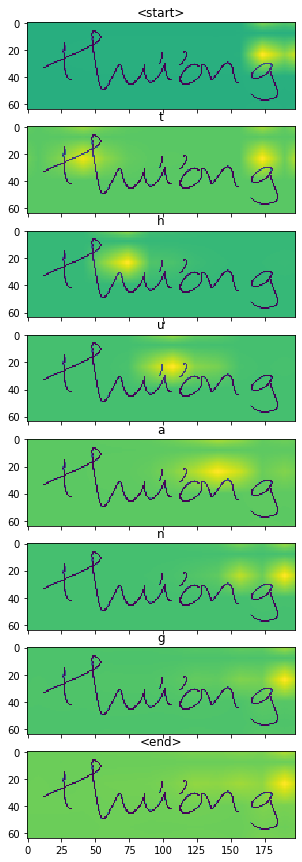

In [37]:
sample_index = 0
sample_image, sample_predict, sample_weigth = imgs[sample_index], predicts_str[sample_index], weights[:, [sample_index]]
fig, axeses = plt.subplots(len(sample_predict), figsize=(15,15), sharex=True, sharey=True)

for i, axes in enumerate(axeses.ravel()):
    weight = weights[i].reshape(-1, config['batch_size'], img_rows // 16, img_cols // 16) # 16 is factor that DenseNet reduce the original image size
    weight_numpy = weight.cpu().numpy()[:,sample_index,:].squeeze()
    weight_image = skimage.transform.resize(weight_numpy, (img_rows, img_cols))
    
    img = sample_image.squeeze().permute(1,2,0).cpu().numpy()[:,:,0]
    
    alpha = 0.5
    blend = img * alpha + weight_image * (1-alpha)
    
    axes.set_title(sample_predict[i])
    axes.imshow(blend)
plt.plot();

# Calc CER, WER on the test set

## CER

In [38]:
import editdistance as ed

In [39]:
from tqdm.notebook import tqdm

In [41]:
total_characters = 0
total_words = 0
CE = 0
WE = 0
log_interval = 10

t = tqdm(test_loader)
with torch.no_grad():
    for (imgs, targets, targets_onehot, lengths) in t:
        batch_size = imgs.size(0)
        
        start_input = torch.zeros(1, batch_size, vocab_size)
        start_input[0,0, char2int[SOS_CHAR]] = 1
        start_input = start_input.to(device)
        imgs = imgs.to(device)
        
        img_features = encoder(imgs)
        outputs, weights = decoder.greedy(img_features, start_input)
        
        _, index = outputs.topk(1, -1)
        predicts = index.squeeze().transpose(0, 1) # [B, T]
        predicts_str = []
        for predict in predicts:
            s = [int2char[x.item()] for x in predict]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            predicts_str.append(s[:eos_index])

        targets_str = []
        for target in targets.transpose(0, 1).squeeze():
            s = [int2char[x.item()] for x in target]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            targets_str.append(s[:eos_index])
        
        assert len(predicts_str) == len(targets_str)
        for i in range(len(predicts_str)):
            CE += ed.distance(predicts_str[i], targets_str[i])
        total_characters += lengths.sum().item()
        
        for i in range(len(predicts_str)):
            WE += 1 if np.array_equal(np.array(predicts_str[i]), np.array(targets_str[i])) else 0
        total_words += len(predicts_str)
        
        t.update()

In [42]:
CER = CE / total_characters
WER = WE / total_words
print('CER', CER)
print('WER', WER)

CER 0.12835660178420538
WER 0.539120047780211


In [40]:
total_characters = 0
total_words = 0
CE = 0
WE = 0
log_interval = 10

t = tqdm(test_loader)
with torch.no_grad():
    for (imgs, targets, targets_onehot, lengths) in t:
        batch_size = imgs.size(0)
        
        start_input = torch.zeros(1, batch_size, vocab_size)
        start_input[0,0, char2int[SOS_CHAR]] = 1
        start_input = start_input.to(device)
        imgs = imgs.to(device)
        
        img_features = encoder(imgs)
        outputs, weights = decoder.greedy(img_features, start_input)
        
        outputs = torch.nn.functional.softmax(outputs.transpose(0,1), dim=2)
        
        predicts = [beam_search_decoder(output) for output in outputs]
        predicts_str = []
        for predict in predicts:
            s = [int2char[x] for x in predict]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            predicts_str.append(s[:eos_index])

        targets_str = []
        for target in targets.transpose(0, 1).squeeze():
            s = [int2char[x.item()] for x in target]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            targets_str.append(s[:eos_index])
        
        assert len(predicts_str) == len(targets_str)
        for i in range(len(predicts_str)):
            CE += ed.distance(predicts_str[i], targets_str[i])
        total_characters += lengths.sum().item()
        
        for i in range(len(predicts_str)):
            WE += 1 if np.array_equal(np.array(predicts_str[i]), np.array(targets_str[i])) else 0
        total_words += len(predicts_str)
        
        t.update()

In [41]:
CER = CE / total_characters
WER = WE / total_words
print('CER', CER)
print('WER', WER)

CER 0.13083923457140934
WER 0.5284093171411507
